In [1]:
%matplotlib inline

import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generator/")

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.stats
plt.style.use("project_style.mplstyle")
from tqdm import tqdm

import stats
import environments
import trajectory_generator
import analysis_tools

In [2]:
def error_kde(errors, n, ylim, bw = None):
    kdes = np.zeros((n, errors.shape[-1]))
    eval_errs = np.linspace(0, ylim, n)
    
    for i in range(errors.shape[-1]):
        kernel = scipy.stats.gaussian_kde(errors[:,i], bw_method = bw)
        kdes[:, i] = kernel(eval_errs) 
    return kdes

def inset_walls(ax, walls, scale = 0.2):
    w = np.amax(np.abs(walls))*1.1*scale
    h = w
    subax = ax.inset_axes(bounds = [0.65, 0.65, w, h])
    for wall in walls:
        subax.plot(*walls.T, "w", linewidth = 0.25)
        subax.axis("equal")
        subax.axis("off")

In [3]:
name = "al1_10_l2_0"
path = f"../models/{name}"
model, params = analysis_tools.load_model(path, device = "cpu", model_type = "RNN") # model of interest

timesteps = 10000 # timesteps per sequence
samples = 100 # of samples for each environment

Text(0, 0.5, 'Euclidean Error')

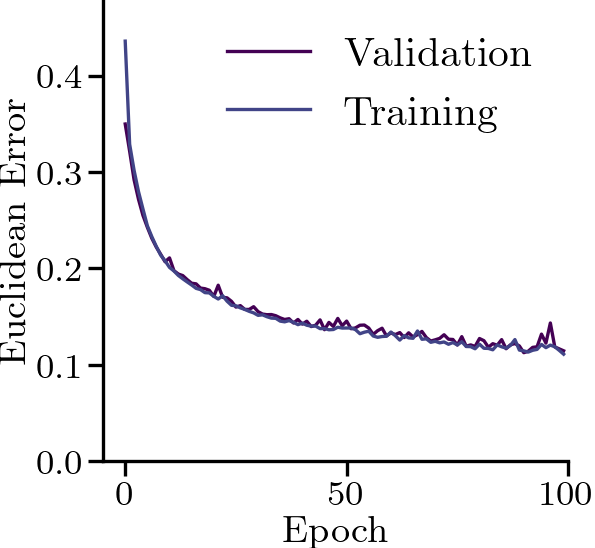

In [4]:
training_losses = np.load(f"{path}/RNN_metrics.npz")
val_euclid = training_losses["val_euclid"]
train_euclid = training_losses["train_euclid"]
plt.figure(figsize = (2,2))
plt.plot(val_euclid, label = "Validation")
plt.plot(train_euclid, label = "Training") # first train step is misleading
plt.axis([-5, len(val_euclid), 0.0,  np.amax(train_euclid)*1.1])
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Euclidean Error")
# plt.savefig(f"./figures/{name}_RNN_training_history")

In [5]:
environments = environments.Environments()
dg = trajectory_generator.DataGenerator()
walls = environments.envs
env_names = list(environments.envs) 

loss = np.zeros((len(env_names), samples, timesteps))
random_baseline = np.zeros((len(env_names), samples, timesteps))
zero_baseline = np.zeros((len(env_names), samples, timesteps))

In [6]:
for i, env in enumerate(tqdm(env_names)):
    sequence = [env]
    # sample environment several times
    for j in range(samples):
        x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = timesteps, context = params["context"], trajectories = True)
        dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
        _, _, _, preds = model.inference(dataset)
        loss[i, j] = np.linalg.norm(preds - r, axis = -1)
        r_random = dg.generate_points(1, timesteps, walls[env]).squeeze()
        random_baseline[i,j] = np.linalg.norm(preds - r_random, axis = -1)
        zero_baseline[i,j] = np.linalg.norm(preds, axis = -1)

100%|██████████| 6/6 [44:03<00:00, 440.58s/it]


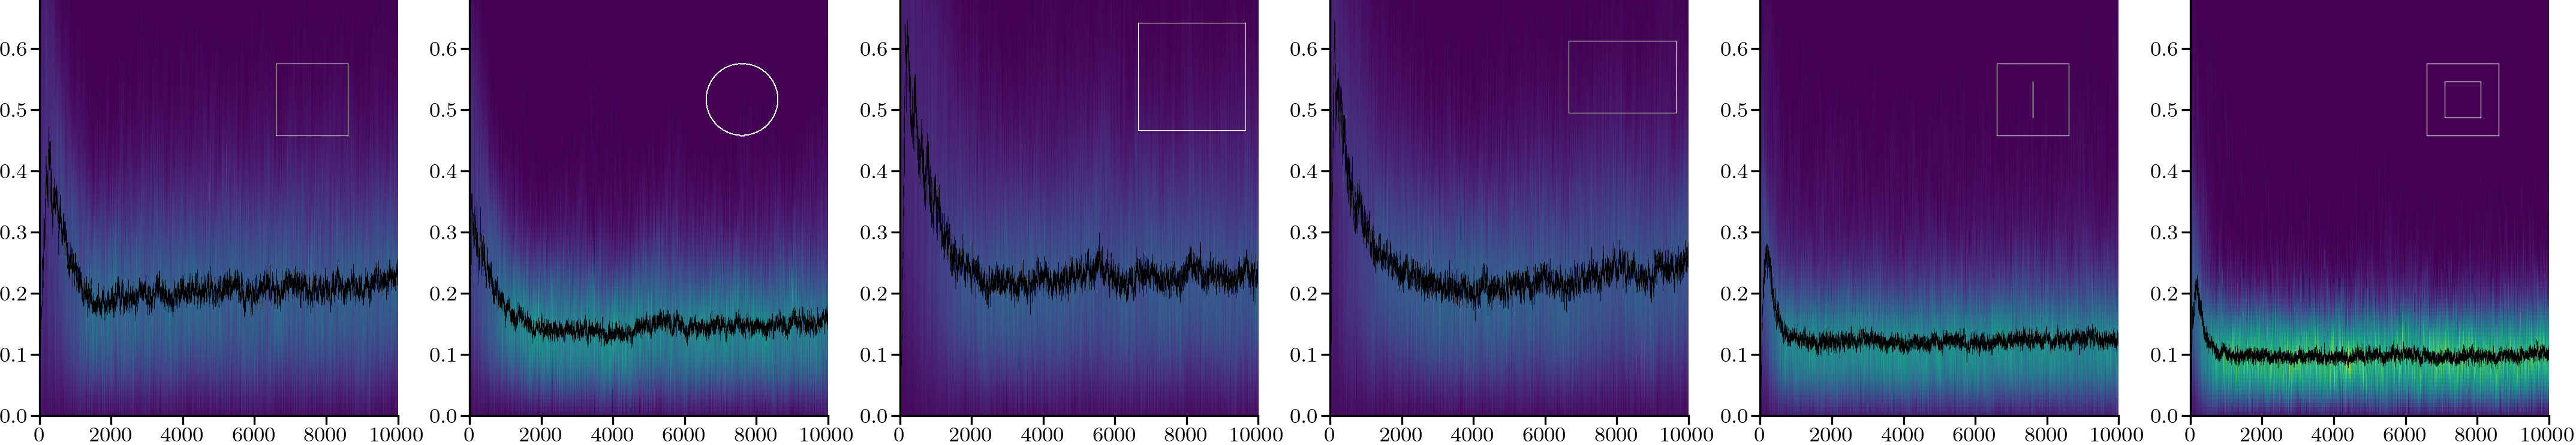

In [72]:
fig, ax = plt.subplots(1, len(env_names), figsize = (18, 3))

ylim = np.percentile(loss.flatten(), 99) # visualize up to 99th percentile
burn_in = 100 # exclude very first steps due to low error in some plots!


vmax = np.amax([np.amax(error_kde(current_loss[:,burn_in:], 100, ylim)) for current_loss in loss])  

for i, current_loss in enumerate(loss):    
    kde = error_kde(current_loss[:,burn_in:], 100, ylim)

    ax[i].imshow(kde, origin = "lower", aspect= "auto", extent = [0, timesteps, 0, ylim], vmin = 0, vmax = vmax)#, cmap = "Greens")

    ax[i].plot(np.median(current_loss, axis = 0), "-k", linewidth = 0.1)

    inset_walls(ax[i], walls[env_names[i]])
    ax[i].set_ylim([0, ylim])

plt.savefig("./figures/error_kdes.png", dpi = 300)


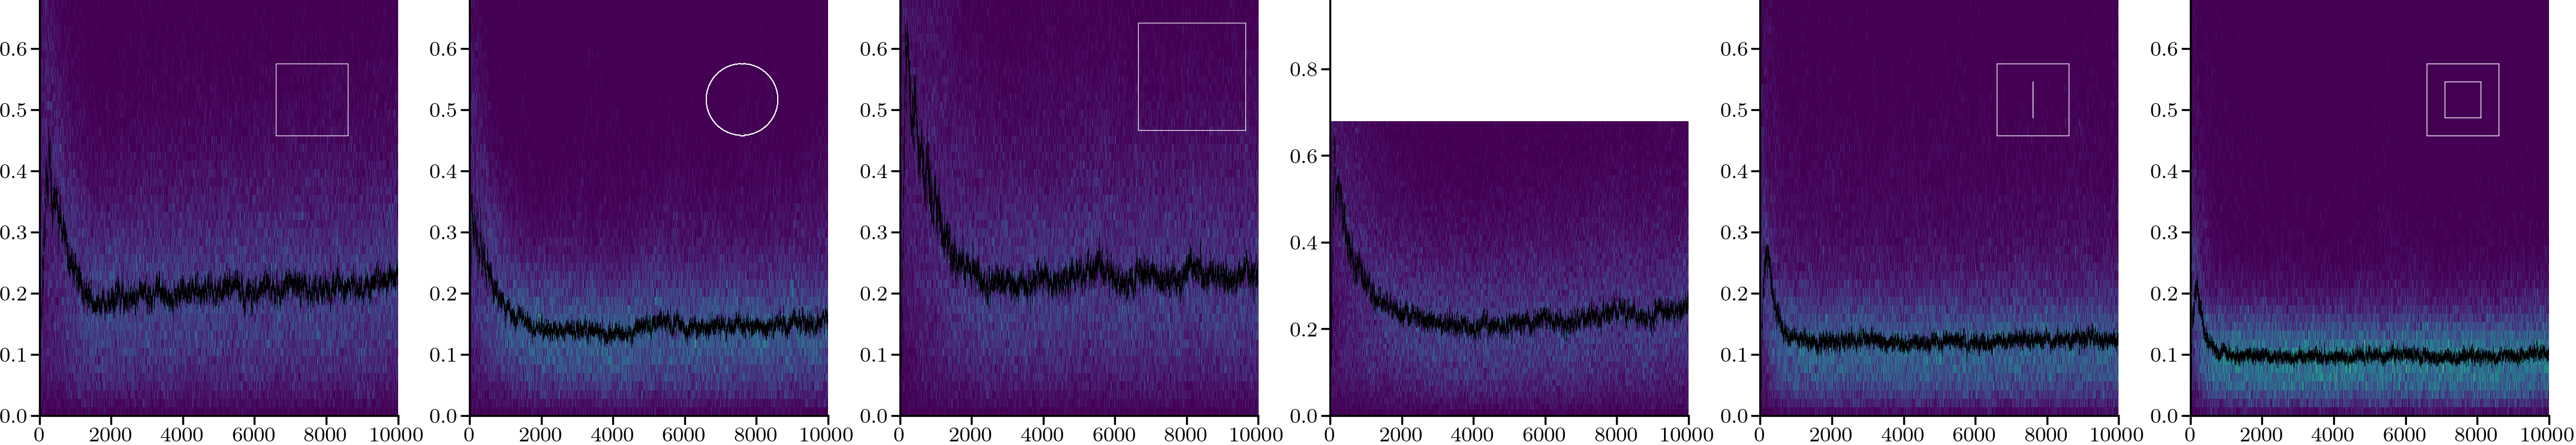

In [85]:
ny = 50
hist = np.zeros((len(env_names), ny, timesteps))

fig, ax = plt.subplots(1, len(env_names), figsize = (18, 3))

ybins = np.linspace(0, ylim, ny)
xbins = np.linspace(0, timesteps-1, timesteps-burn_in)
timestamps = np.array([xbins for i in range(samples)])

vmax = np.amax( [np.amax(np.histogram2d(timestamps.ravel(), current_loss[:,burn_in:].ravel(),bins = [xbins, ybins])[0]) for current_loss in loss])


for i, current_loss in enumerate(loss):
    hist = np.histogram2d(timestamps.ravel(), current_loss[:,burn_in:].ravel(),bins = [xbins, ybins])[0]
    ax[i].imshow(hist.T, origin = "lower", aspect= "auto", extent = [0, timesteps, 0, ylim], vmax = vmax) 
    ax[i].plot(np.median(current_loss, axis = 0), "-k", linewidth = 0.1)
    inset_walls(ax[i], walls[env_names[i]])

plt.savefig("./figures/error_hists.png", dpi = 300)


In [9]:
# Show trajectories for square environments
x, r, v, c = analysis_tools.test_dataset(['square']*2, timesteps = 500, context = params["context"], trajectories = True)
dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(x))] # repackage
_, _, _, preds = model.inference(dataset)

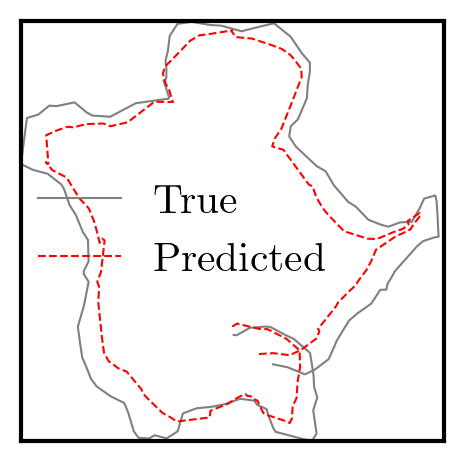

In [10]:
a = 0
b = 250
c = 380

plt.figure(figsize=(2, 2))
plt.plot(r[a,b:c,0], r[a,b:c,1], "gray", label = "True", linewidth = 0.5)
plt.plot(preds[a,b:c,0], preds[a,b:c,1], "--r", label = "Predicted", linewidth = 0.5)
for wall in walls["square"]:
    plt.plot(wall[:,0], wall[:,1], "k", linewidth = 1)
plt.axis("off")
plt.legend()

# plt.savefig("./figures/pred_trajectory")